In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [197]:
import pathlib
import re
data_root = pathlib.Path('dataset/test/imgs/')
all_image_paths = [str(path) for path in list(data_root.glob('*'))]
all_image_paths.sort(key=lambda x: int(re.findall(r'\d+', x)[0]))
images = [cv2.imread(x, cv2.IMREAD_GRAYSCALE) for x in all_image_paths]
# images_origin = [cv2.imread(x) for x in all_image_paths]

In [198]:
# initial parameters
filter_proj_count = 2
line_width_min_limit = 0
pixel_min = 20
binary_boundary = 140
sep_distance_thresh = 30    
closet_line_rate = 0.13

In [207]:
def tackle_close_seps(arr):    
    global sep_distance_thresh 
    for _ in range(4):
        flag = 1
        discard = set()
        addition = set()
        for i in range(1, len(arr)):
            if arr[i] - arr[i-1] <= sep_distance_thresh:
                flag = 0
                discard.add(arr[i-1])
                discard.add(arr[i])
                addition.add(int((arr[i-1] + arr[i])/2))
        arr = sorted(list(set(arr).difference(discard).union(addition)))
        if flag == 1:
            break
    return arr

def img_preprocess(img):
    _, thresh = cv2.threshold(img, binary_boundary, 255, cv2.THRESH_BINARY_INV)
#     kernel1 = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2)) 
    kernel2 = cv2.getStructuringElement(cv2.MORPH_RECT, (4, 4)) 
#     handled_1 = cv2.erode(thresh, kernel1, iterations = 1) # 先腐蚀
    handled_2 = cv2.dilate(thresh, kernel2, iterations = 1) # 再膨胀
    handled_2 = handled_2/255
    return handled_2

def draw_seps(img, *args):
    lineThickness = 3
    for arg in args:
        cv2.line(img, (0, arg), (img.shape[1], arg), (255,0,0), lineThickness)
        
def get_proj(img):
    return np.sum(img, axis=1)

import more_itertools as mit
from statistics import median, mean
def find_sep(arr:list):
    idx0, idx1 = pixel_min, len(arr) - pixel_min
    a = arr[idx0:idx1]
    zero_idx_arr = [i+idx0 for i, e in enumerate(a) if e <= filter_proj_count]
    group_arr = [list(group) for group in mit.consecutive_groups(zero_idx_arr)]
    return [int(median(x)) for x in group_arr if len(x) >= line_width_min_limit]

def split_image(img, sep1, sep2):
#     height, width, _ = img.shape
    height, width = img.shape
    crop_img1 = img[0:sep1, 0:width]
    crop_img2 = img[sep1:sep2, 0:width]
    crop_img3 = img[sep2:height, 0:width]
    return [crop_img1, crop_img2, crop_img3]

#     plt.plot(proj, range(len(proj))[::-1])
def find_closest_line(height, arr):
    sep13, sep23 = int(height/3), int(height*2/3)
    thresh = height * closet_line_rate
    ans = []
    for line in arr:
        if abs(line - sep13) <= thresh or abs(line - sep23) <= thresh:
            ans.append(line)
    return ans

def allow_max1line_1part(height, arr):
    middle = height/2
    up_part = [x for x in arr if x <= middle]
    down_part = [x for x in arr if x > middle]
    up_diff = [middle-x for x in up_part]
    down_diff = [x-middle for x in down_part]
    ans = []
    if up_diff:
        up_val = up_part[up_diff.index(min(up_diff))]
        ans.append(up_val)
    if down_diff:
        down_val = down_part[down_diff.index(min(down_diff))]
        ans.append(down_val)
    return ans

def tackle_1sep(height, arr):
    value = arr[0]
    if value < height/2:
        arr.append(int((height - value) / 2) + value)
    else:
        arr.insert(0, int(value/2))
    return arr

def get_final_seps(images):
    seps_arr = []
    for img in images:    
        height = img.shape[0]
        handled = img_preprocess(img)
        proj = get_proj(handled)
        seps = find_sep(proj)
        seps = tackle_close_seps(seps)
        if len(seps) > 1:
            seps = find_closest_line(height, seps)
        seps = allow_max1line_1part(height, seps)
        if len(seps) == 1:
            seps = tackle_1sep(height, seps)
        elif len(seps) == 0:
            seps = [int(height/3), int(height*2/3)]
        seps_arr.append(seps)
    return seps_arr

def get_final_splitted_images(images):
    seps_arr = get_final_seps(images)
    ans = []
    for i in range(len(images)):
        ans.append(split_image(images[i], seps_arr[i][0], seps_arr[i][1]))
    return ans

In [208]:
final = get_final_splitted_images(images)

In [210]:
len(final)

13647

下面是琐碎的练习代码

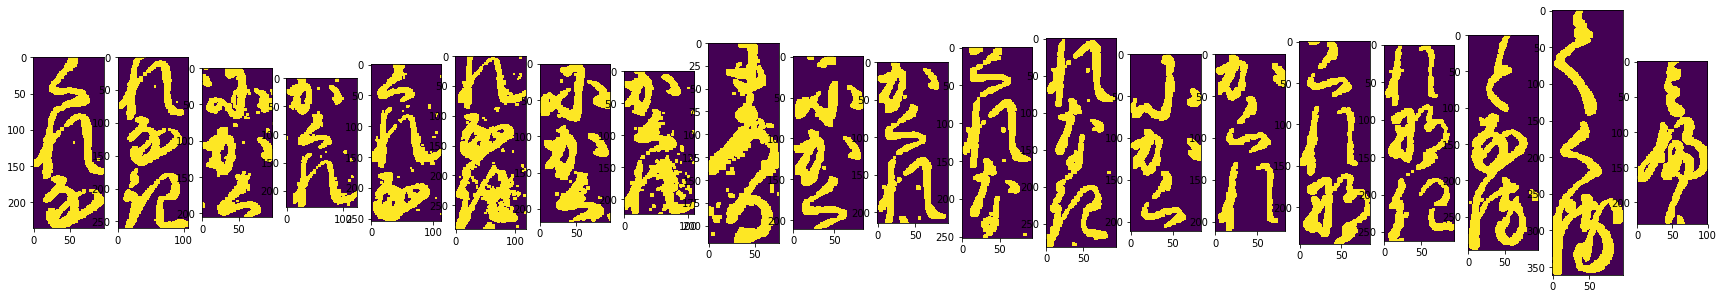

In [193]:
plt.figure(figsize=(30,20))
for i in range(0, 20):    
    img = cv2.imread(all_image_paths[i], cv2.IMREAD_GRAYSCALE)
    plt.subplot(1,20,i+1)
    plt.imshow(img_preprocess(img))                   

In [194]:
seps_dict = {
    "seps3more": [],
    "seps2": [],
    "seps1": [],
    "seps0": []
}
seps_arr = []
for i in range(len(all_image_paths)):    
    img = cv2.imread(all_image_paths[i], cv2.IMREAD_GRAYSCALE)
    height = img.shape[0]
    handled = img_preprocess(img)
    proj = get_proj(handled)
    seps = find_sep(proj)
    seps = tackle_close_seps(seps)
    if len(seps) > 1:
        seps = find_closest_line(height, seps)
    seps = allow_max1line_1part(height, seps)
    if len(seps) == 1:
        seps = tackle_1sep(height, seps)
    elif len(seps) == 0:
        seps = [int(height/3), int(height*2/3)]
    seps_arr.append(seps)
    N = len(seps)
    if N >= 3:
        seps_dict["seps3more"].append(i)
    elif N == 2:
        seps_dict["seps2"].append(i)
    elif N == 1:
        seps_dict["seps1"].append(i)
    else:
        seps_dict["seps0"].append(i)

In [195]:
for k in seps_dict.keys():
    print(k, len(seps_dict[k]))

seps3more 0
seps2 200
seps1 0
seps0 0


<Figure size 2160x1440 with 0 Axes>

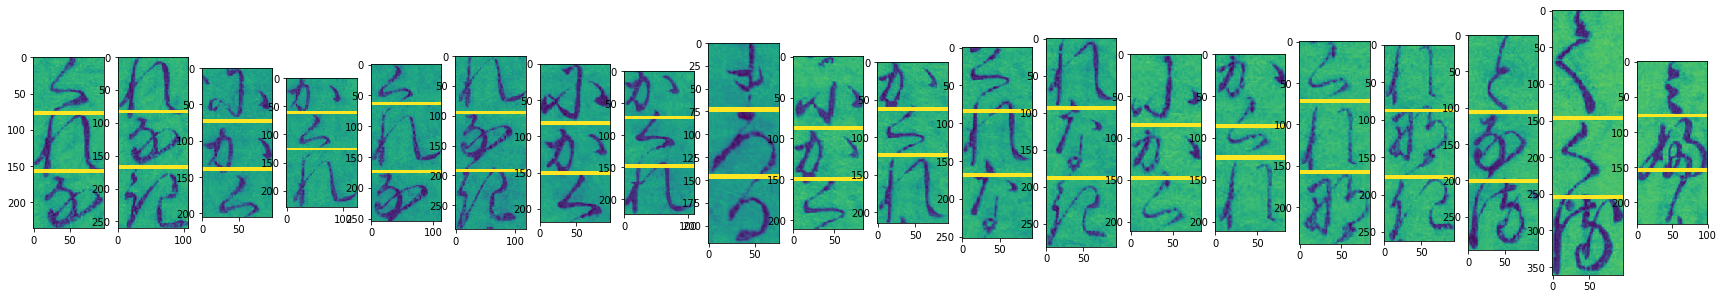

<Figure size 2160x1440 with 0 Axes>

<Figure size 2160x1440 with 0 Axes>

In [196]:
for k in seps_dict.keys():  
    plt.figure(k, figsize=(30,20))
    for i in range(20):    
        if len(seps_dict[k]) <= i:
            continue
        img = cv2.imread(all_image_paths[seps_dict[k][i]], cv2.IMREAD_GRAYSCALE)
        draw_seps(img, *seps_arr[seps_dict[k][i]])
        plt.subplot(1,20,i+1)
        plt.imshow(img)   